In [1]:
%matplotlib inline

# Entrenamiento de la red

## Resultados de las redes sin entrenar

En la clase anterior creamos una red neuronal, de dos maneras, desde cero y a través del transfer learning. En el primer caso (desde cero) todos sus parámetros se han inicializado aleatoriamente, mientras que en el segundo (transfer learning) solo los de la última capa son aleatorios. En ambos casos, al inicializarse estos aleatoriamente va a hacer que la red no sea capaz de hacer su cometido.

Veamos un ejemplo con las dos redes. Nos vamos a descargar el conjunto de datos ``CIFAR-10`` desde el conjunto de datos de Pytorch, vamos a crear los datasets, vamos a crear los dos tipos de redes, y a las dos les vamos a dar una imagen, a ver si son capaces de predecir bien qué hay en ella

### Dataset

Descargamos y creamos el dataset

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

# Descargamos y creamos el dataset
dataset_train = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

dataset_test = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


### Dataloader

Creamos un dataloader

In [3]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader = DataLoader(dataset_train, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(dataset_test, batch_size=BATCH_SIZE)

### Redes

Creamos las redes neuronales desde cero y desde transfer learning

In [4]:
from torch import nn

# Creamos la red neuronal desde cero
class NeuralNetworkFromScratch(nn.Module):
    def __init__(self):
        super(NeuralNetworkFromScratch, self).__init__()   # Se inicializa el módulo nn.Module
        self.flatten = nn.Flatten()             # Se crea una primera capa que aplana la imagen de entrada
        self.linear_relu_stack = nn.Sequential( # Se crea una módulo de arquitectura secuencial:
            nn.Linear(3*32*32, 512),                # Se añade una primera capa lineal que está preparada 
                                                    # para que le entre un vector de 28*28 (784)
                                                    # y sacará un vector de 512
            nn.ReLU(),                              # Se añade una no linealidad
            nn.Linear(512, 512),                    # Se añade una segunda capa lineal que le entran 512 
                                                    # datos y saca 512 datos
            nn.ReLU(),                              # Se añade una no linealidad
            nn.Linear(512, 10)                      # Se añade una tercera capa lineal que le entran 512 
                                                    # datos y saca un array de tamaño 10 (el número
                                                    # de etiquetas)
        )
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)                         # Se pasa la imagen por la capa de aplanado
        logits = self.linear_relu_stack(x)          # Se pasa el vector resultante por la red
        #probs = self.softmax(logits)
        return logits

model_scratch = NeuralNetworkFromScratch()

In [5]:
from torchvision import models

# Creamos la red neuronal mediante transfer learning
model_tl = models.resnet18(pretrained=True)
model_tl.fc = nn.Linear(512, 10)

### Muestra del dataset

Cogemos una muestra aletoria del dataset

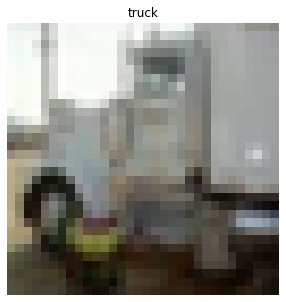

In [6]:
from random import randint
import matplotlib.pyplot as plt

# Cogemos una muestra al azahar
idx = randint(0, len(train_dataloader)-1)
sample_dataloader = next(iter(train_dataloader))
sample_dataloader_images, sample_dataloader_labels = sample_dataloader
idx = randint(0, len(sample_dataloader_images)-1)
sample_image = sample_dataloader_images[idx]
sample_label = sample_dataloader_labels[idx]

labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

figure = plt.figure(figsize=(5, 5))
plt.title(labels_map[sample_label.item()])
plt.axis("off")

plt.imshow(sample_image.permute(1,2,0).squeeze())  
# permute cambia el orden de las dimensiones, ya que las
# imágenes tienen tamaño 3x32x32, pero necesitamos que
# las dimensiones sean 32x32x3 para que matplotlib las pinte
# así que se permutan poniendo primero las dos de 32 y 
# la última la de 3

# squeeze elimina todas las dimensiones 1 de un tensor, 
# si se le mete un tensor de dimensiones (Ax1xBxCx1xD) 
# devuelve un tensor de dimensiones (AxBxCxD)

plt.show()

Se la pasamos a las redes

In [7]:
# Le pasamos la imagen a la red neuronal creada desde cero
logits_scratch = model_scratch(sample_dataloader_images)
print(f"La red ha devuelto {logits_scratch.shape} logits")

La red ha devuelto torch.Size([64, 10]) logits


La red ha creado 64 logits porque hemos creado un Dataloader con un batch size de 68, es decir hemos hecho que se divida el Dataset que contienen 50.000 imágenes de entrenamiento en batches con 64 imágenes cada uno.

Como se le ha pasado a la red ese Dataloader con 64 imágenes devuelve 64 resultados

In [8]:
# La red ha devuelto 64 logits, por lo que nos quedamos con el 
# número idx que es el que se ha representado antes
probs_scratch = logits_scratch.softmax(dim=1)
label = probs_scratch[idx].argmax().item()
print(f"La red cree que en la imagen hay {labels_map[label]}")

La red cree que en la imagen hay horse


In [10]:
# Le pasamos la imagen a la red neuronal creada desde transfer learning

# En este caso la red espera un batch de imágenes, además de 3 canales (color),
# mientras que ahora tenemos una sola imagen de un solo canal (blanco y negro), 
# por lo que expandimos el tensor que se le mete a la entrada para que la red se 
# piense que tiene un batch de varias imágenes de 3 canales (en color)
sample_image_expand = sample_image.expand(5, 3, 32, 32)

# Introducimos este tensor a la red, esto nos dará 5 predicciones
label_tl = model_tl(sample_image_expand)

# Cogemos una de las predicciones
label = label_tl[0].argmax().item()
print(f"La red cree que en la imagen hay {labels_map[label]}")

La red cree que en la imagen hay airplane


## Entrenamiento de la red neuronal

Como podemos ver, ninguna de las dos ha acertado, por lo que pasamos a entrenarlas

### Dataloader

Primero creamos unos dataloaders para entrenar por lotes

In [12]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader = DataLoader(dataset_train, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(dataset_test, batch_size=BATCH_SIZE)

### Función de pérdida

A continuación creamos una función de pérdida. Como recordatorio, la función de pérdida es lo que nos permite saber cómo de equivocada está la red, y es la función que queremos minimizar. Para calcular esta función de pérdida comparamos el resultado que nos ha dado la red, con el que sabemos a través de las etiquetas que debería haber 

Las funciones de pérdida comunes incluyen [``nn.MSELoss``](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) (error cuadrático medio) para tareas de regresión y [``nn.NLLLoss``](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) (probabilidad de registro negativo) para clasificación.

En este caso estamos en un problema de clasificación

[``nn.CrossEntropyLoss``](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) combina ``nn.LogSoftmax`` y ``nn.NLLLoss``.

Si te fijas, en la red creada desde cero hemos comentado la capa de `softmax` para así poder usar la función ``nn.CrossEntropyLoss``. Es mejor no usar la capa de `softmax` y usar la función ``nn.CrossEntropyLoss`` que ya incluye la parte de `softmax`. Esto es debido a motivos computacionales, haciéndolo así es más estable. Ahora no es el momento de entender esto

Pasamos los logits de salida de nuestro modelo a ``nn.CrossEntropyLoss``, que normalizarán los logits y calcularán el error de predicción.

In [13]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

### Optimizador

El optimizador es el proceso por el que minimizamos la función de pérdida, haciendo que la diferencia entre lo que predice la red y lo que de verdad es sea lo menos posible

La optimización es el proceso de ajustar los parámetros del modelo para reducir el error del modelo en cada paso de entrenamiento. **Los algoritmos de optimización** definen cómo se realiza este proceso (en este ejemplo usamos Descenso de gradiente estocástico). Toda la lógica de optimización está encapsulada en el objeto ``optimizer``. Aquí usamos el optimizador SGD; Además, hay muchos [optimizadores diferentes](https://pytorch.org/docs/stable/optim.html) disponibles en PyTorch, como `ADAM` y `RMSProp`, que funcionan mejor para diferentes tipos de modelos y datos.

Inicializamos el optimizador registrando los parámetros del modelo que necesitan ser entrenados y pasando el hiperparámetro de tasa de aprendizaje.

Vamos a entrenar solo la red neuronal creada desde cero, ya que es un perceptron multicapa, mientras que la creada mediante transfer learning es una red convolucional que aun no se ha explicado

In [63]:
import torch

LR = 1e-2

optimizer = torch.optim.SGD(model_scratch.parameters(), lr=LR)

### Ciclo de entrenamiento

Dentro del ciclo de entrenamiento, la optimización ocurre en tres pasos:
 * Llamada a ``optimizer.zero_grad()`` para restablecer los gradientes de los parámetros del modelo. Los degradados se suman por defecto; para evitar el doble conteo, los ponemos a cero explícitamente en cada iteración.
 * Retropropagación de la pérdida de predicción con una llamada a ``loss.backwards()``. PyTorch deposita los gradientes de pérdida con cada parámetro.
 * Una vez que tenemos nuestros degradados, llamamos ``optimizer.step()`` a ajustar los parámetros por los degradados recogidos en la backward.

Definimos ``train_loop`` que recorre nuestro código de optimización y ``test_loop`` que evalúa el rendimiento del modelo en comparación con nuestros datos de prueba.

In [64]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # X and y to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            # X and y to device
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [65]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model_scratch.to(device)

Using cuda device


NeuralNetworkFromScratch(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [66]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model_scratch, loss_fn, optimizer)
    test_loop(test_dataloader, model_scratch, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301011  [    0/50000]
loss: 2.280377  [ 6400/50000]
loss: 2.179036  [12800/50000]
loss: 2.188025  [19200/50000]
loss: 2.088279  [25600/50000]
loss: 2.043051  [32000/50000]
loss: 2.139561  [38400/50000]
loss: 1.977216  [44800/50000]
Test Error: 
 Accuracy: 29.6%, Avg loss: 1.957990 

Epoch 2
-------------------------------
loss: 2.010353  [    0/50000]
loss: 1.997623  [ 6400/50000]
loss: 1.750316  [12800/50000]
loss: 1.986206  [19200/50000]
loss: 1.980092  [25600/50000]
loss: 1.944378  [32000/50000]
loss: 1.993266  [38400/50000]
loss: 1.847662  [44800/50000]
Test Error: 
 Accuracy: 33.9%, Avg loss: 1.859632 

Epoch 3
-------------------------------
loss: 1.843515  [    0/50000]
loss: 1.849531  [ 6400/50000]
loss: 1.615582  [12800/50000]
loss: 1.875607  [19200/50000]
loss: 1.918449  [25600/50000]
loss: 1.867430  [32000/50000]
loss: 1.910365  [38400/50000]
loss: 1.772202  [44800/50000]
Test Error: 
 Accuracy: 36.6%, Avg loss: 1.789821 

Epoc

### Inferencia

Veamos ahora qué tal predice. Cogemos una muestra aletoria del dataset

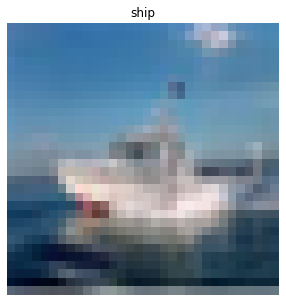

In [67]:
from random import randint
import matplotlib.pyplot as plt

# Cogemos una muestra al azahar
idx = randint(0, len(train_dataloader)-1)
sample_dataloader = next(iter(train_dataloader))
sample_dataloader_images, sample_dataloader_labels = sample_dataloader
idx = randint(0, len(sample_dataloader_images)-1)
sample_image = sample_dataloader_images[idx]
sample_label = sample_dataloader_labels[idx]

labels_map = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

figure = plt.figure(figsize=(5, 5))
plt.title(labels_map[sample_label.item()])
plt.axis("off")

plt.imshow(sample_image.permute(1,2,0).squeeze())  
# permute cambia el orden de las dimensiones, ya que las
# imágenes tienen tamaño 3x32x32, pero necesitamos que
# las dimensiones sean 32x32x3 para que matplotlib las pinte
# así que se permutan poniendo primero las dos de 32 y 
# la última la de 3

# squeeze elimina todas las dimensiones 1 de un tensor, 
# si se le mete un tensor de dimensiones (Ax1xBxCx1xD) 
# devuelve un tensor de dimensiones (AxBxCxD)

plt.show()

Se la pasamos a la red

In [69]:
# Le pasamos la imagen a la red neuronal creada desde cero
model_scratch.to("cpu")
logits_scratch = model_scratch(sample_dataloader_images)

# La red ha devuelto 64 logits, por lo que nos quedamos con el 
# número idx que es el que se ha representado antes
probs_scratch = logits_scratch.softmax(dim=1)
label = probs_scratch[idx].argmax().item()
print(f"La red cree que en la imagen hay {labels_map[label]}")

La red cree que en la imagen hay ship
